In [19]:
import numpy as np
import pandas as pd
import scipy

import hdf5plugin
import h5py

import matplotlib.pyplot as plt
import matplotlib.gridspec 
%matplotlib inline

import warnings

import pathlib


In [21]:
base_path = pathlib.Path('/mnt_blpc3/datax/scratch/andresl/starlink-pipeline-runs/sample-run2/batches/')

tables = next(base_path.walk())[2]
num = 0
for table in tables:
    num += len(pd.read_csv(base_path / table))
print(num)

6301


In [24]:
df = pd.read_csv('/mnt_blpc3/datax/scratch/andresl/starlink-pipeline-runs/sample-run2/batches/batch_009.csv')
df

,frequency_index,frequency,kurtosis,snr,width,flags,source file
0,93696,11251.200459,43.394268,15.446796,0.000040,blip,/datag/pipeline/AGBT21A_996_22/blc00/blc00_gup...
1,94208,11251.200459,42.961510,14.545401,0.000038,blip,/datag/pipeline/AGBT21A_996_22/blc00/blc00_gup...
2,201216,11250.900342,109.004776,481.536108,0.000033,blip,/datag/pipeline/AGBT21A_996_22/blc00/blc00_gup...
3,201728,11250.900345,108.999620,487.221820,0.000033,blip,/datag/pipeline/AGBT21A_996_22/blc00/blc00_gup...
4,203776,11250.893925,15.984489,28.857163,0.000146,blip,/datag/pipeline/AGBT21A_996_22/blc00/blc00_gup...
...,...,...,...,...,...,...,...
479,38129152,11144.931672,3.751147,5.547034,0.000006,blip,/datag/pipeline/AGBT21A_996_22/blc00/blc00_gup...
480,40140800,11139.310440,4.720336,6.880234,0.000006,blip,/datag/pipeline/AGBT21A_996_22/blc00/blc00_gup...
481,40141312,11139.309999,4.540732,6.923001,0.000006,blip,/datag/pipeline/AGBT21A_996_22/blc00/blc00_gup...
482,45243904,11125.052425,138.235090,25.681020,0.000015,blip,/datag/pipeline/AGBT21A_996_22/blc00/blc00_gup...


In [25]:
fname = df['source file'].iloc[0]
fname

'/datag/pipeline/AGBT21A_996_22/blc00/blc00_guppi_59310_05219_TIC230075227_0112.rawspec.0000.h5'

In [26]:
f = h5py.File(fname)
fch1 = f['data'].attrs['fch1']
foff = f['data'].attrs['foff']
nchans = f['data'].attrs['nchans']
tsamp = f['data'].attrs['tsamp']
WINDOW_SIZE = 2**10

In [27]:
fch1 + (foff * nchans), fch1

(np.float64(11063.96484375), np.float64(11251.46484375))

In [28]:
def signal_model(x, mean, stdev, amplitude, noise):
    exponent = -0.5 * ((x - mean) / stdev)**2
    return noise + amplitude * np.exp(exponent)

def fit_gaussian_to_slice(freq_array: np.ndarray, slice_data: np.ndarray):
    return scipy.optimize.curve_fit(
        signal_model, 
        freq_array, 
        slice_data, 
        p0=[
            freq_array[np.argmax(slice_data)], 
            np.abs(foff),
            np.max(slice_data) - np.median(slice_data),
            np.median(slice_data)
        ],
        # slow, screws up scale for some signals
        bounds=np.array([
            (freq_array[-1], freq_array[0]),
            (0, np.inf),
            (np.median(slice_data)*0.25, np.inf),
            (0, np.inf)
        ]).T,
        max_nfev=10_000
    )

def fit_frequency_gaussians(freq_array: np.ndarray, block: np.ndarray):
        """
        Fits a Gaussian to each frequency slice of the block.
        Returns parameters and covariance for each slice, with dimensions (num_slices, 4) and (num_slices, 4, 4).
        Failed fits result in NaN parameters for that slice."""
        all_params = []
        all_covs = []
        for i in range(block.shape[0]):
            slice_data = block[i, :]
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    params, cov = fit_gaussian_to_slice(freq_array, slice_data)
            except (RuntimeError, ValueError, scipy.optimize.OptimizeWarning) as e:
                # print(e)
                # Return NaN parameters for failed fits
                params = np.full((4,), np.nan)
                cov = np.full((4, 4), np.nan)
            all_params.append(params)
            all_covs.append(cov)
        params = np.array(all_params)
        covs = np.array(all_covs)
        return params, covs

def zap_dc(block, l_idx):
    r_idx = l_idx + WINDOW_SIZE
    COARSE_PER_FINE = 2**20

    r_to_spike = (r_idx + COARSE_PER_FINE//2) % COARSE_PER_FINE
    if r_to_spike > WINDOW_SIZE: return

    spike_idx = WINDOW_SIZE - r_to_spike
    block[:, spike_idx] = (block[:, spike_idx-1] + block[:, spike_idx+1])/2

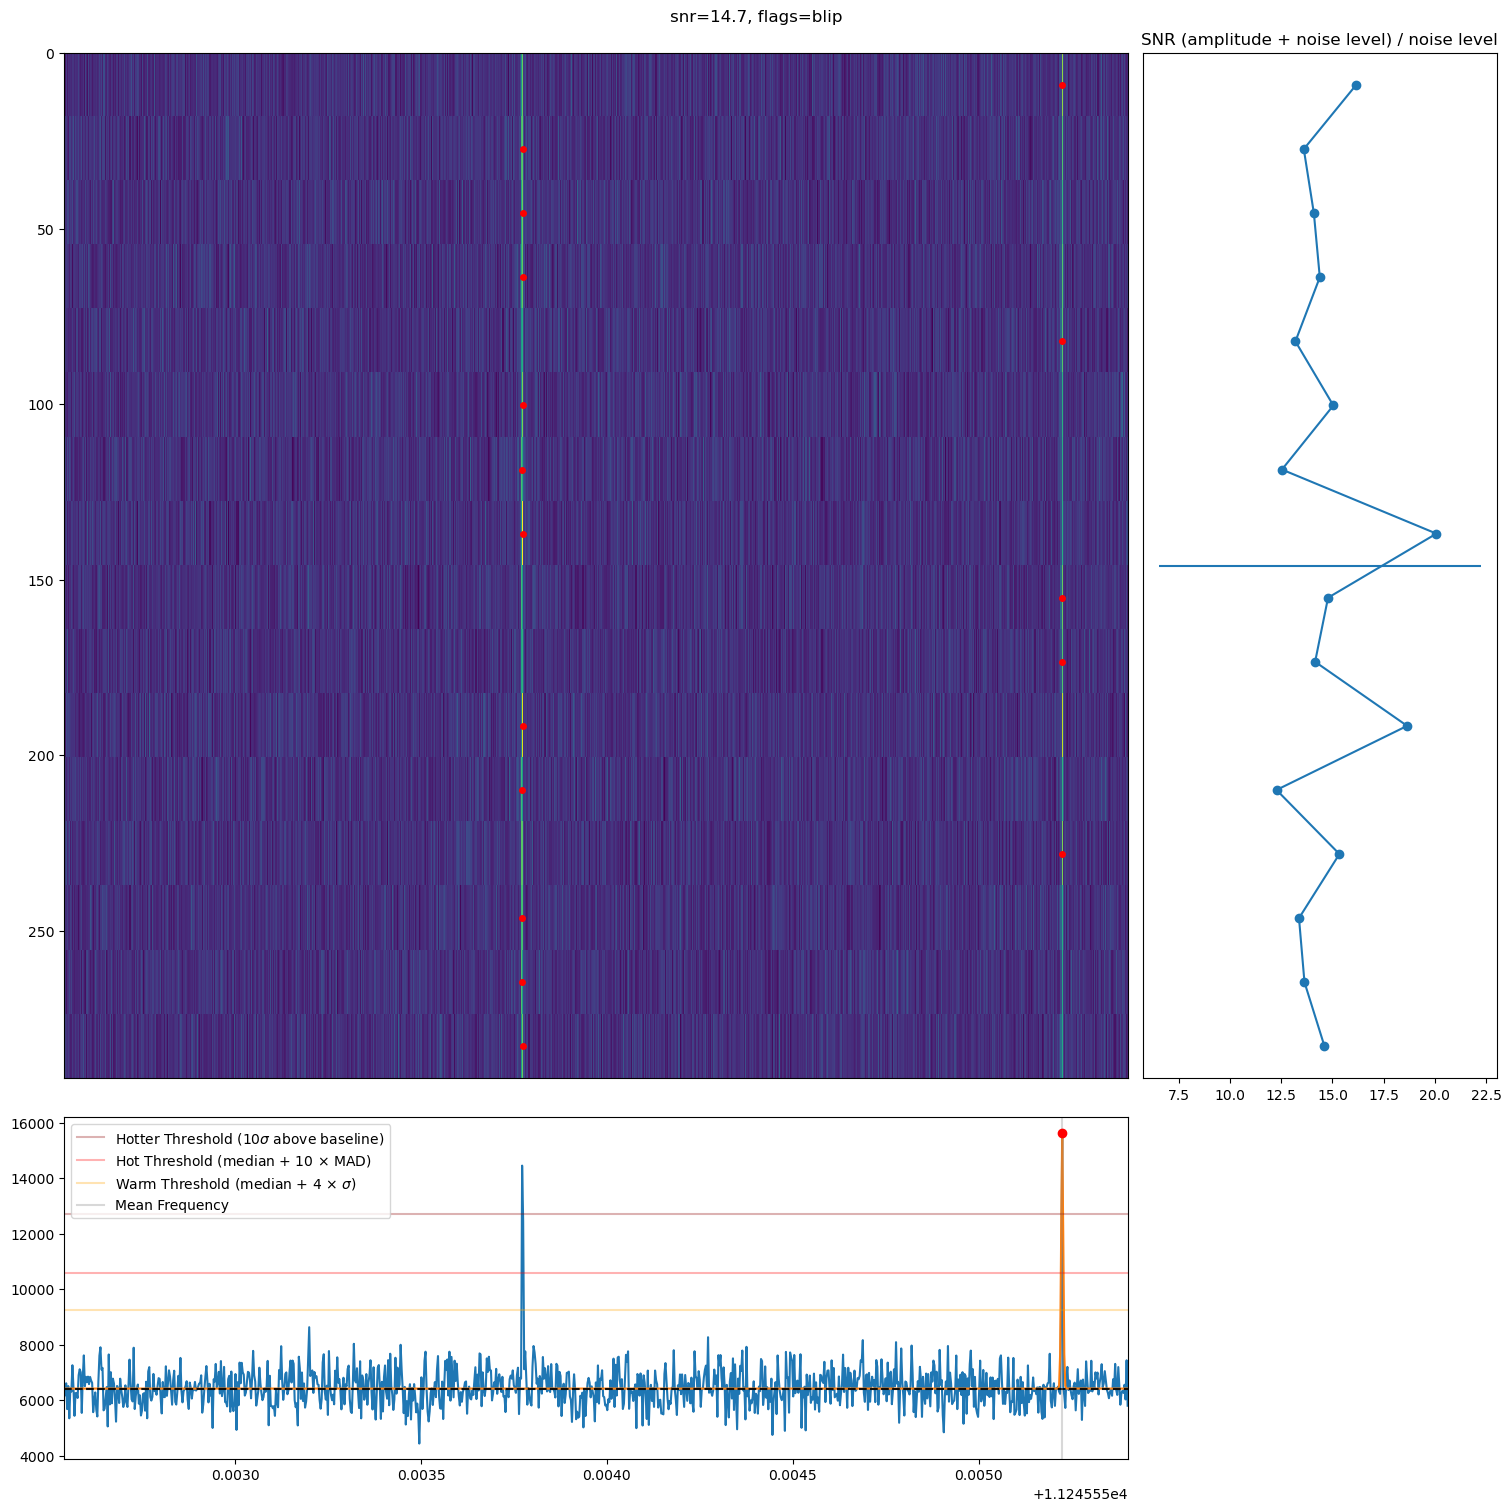

In [45]:
def make_figure(hit, title=None):
    if title is None:
        title = hit['flags'] if not pd.isna(hit['flags']) else '(no flags)'
        title = hit.name + title

    SLICE_IDX = 8

    l_idx = hit['frequency_index']
    data: h5py.Dataset = f['data'][:, 0, l_idx : l_idx+WINDOW_SIZE] # type: ignore
    zap_dc(data, l_idx)
    freqs = np.linspace(
        fch1 + l_idx*foff, 
        fch1 + (l_idx + data.shape[1])*foff,
        data.shape[1],
        endpoint=False
    )
    times = (np.arange(data.shape[0]) + 0.5) * tsamp
    params, _ = fit_frequency_gaussians(freqs, data)

    fig = plt.figure(figsize=(15, 15), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(2, 2, figure=fig, width_ratios=[3, 1], height_ratios=[3, 1])

    im_ax = fig.add_subplot(gs[0, 0])
    snr_ax = fig.add_subplot(gs[0, 1], sharey=im_ax)
    slice_ax = fig.add_subplot(gs[1, 0], sharex=im_ax)

    snr = []
    for time_idx in range(data.shape[0]):
        time_slice = data[time_idx]
        clipped, _, _ = scipy.stats.sigmaclip(time_slice, 3, 3)
        snr.append(
            (np.max(time_slice) - np.mean(clipped)) / np.std(clipped)
        )
    snr = np.array(snr)
    snr_ax.plot(snr, times, marker='o')
    if np.min(snr) < 2:
        snr_ax.axvline(1.0, color='gray')
    snr_others = np.delete(snr, np.argmax(snr))
    snr_others_mad = scipy.stats.median_abs_deviation(snr_others)
    snr_ax.hlines(
        np.mean(times), 
        np.mean(snr_others) - 10*snr_others_mad, 
        np.mean(snr_others) + 10*snr_others_mad
    )
    snr_ax.set_title('SNR (amplitude + noise level) / noise level')
    snr_ax.yaxis.set_visible(False) 

    im_ax.imshow(
        data,
        extent=(
            fch1 + foff*l_idx, fch1 + foff*(l_idx + data.shape[1]),
            data.shape[0] * tsamp, 0
        ),
        aspect='auto',
        interpolation='none'
    )
    im_ax.errorbar(params[:, 0], times, color='red', markersize=4, xerr=params[:, 1], fmt='o')
    im_ax.invert_xaxis()
    im_ax.xaxis.set_visible(False)  # Hide x-axis on main plot

    slice_data = data[SLICE_IDX, :]
    slice_ax.plot(freqs, slice_data)
    slice_ax.plot(freqs, signal_model(freqs, *params[SLICE_IDX]))

    slice_median = params[SLICE_IDX, 3]
    slice_ax.axhline(slice_median, alpha = 0.9, color='black', linestyle='--')

    HOTTER_SIGNIFICANCE = 10
    clipped_slice, _, _ = scipy.stats.sigmaclip(slice_data)
    hotter_threshold = np.mean(clipped_slice) + HOTTER_SIGNIFICANCE * np.std(clipped_slice)
    slice_ax.axhline(hotter_threshold, alpha=0.3, color='darkred', label=f'Hotter Threshold ({HOTTER_SIGNIFICANCE}$\\sigma$ above baseline)')

    hot_threshold = slice_median + 10*scipy.stats.median_abs_deviation(slice_data)
    slice_ax.axhline(hot_threshold, alpha=0.3, color='red', label='Hot Threshold (median + 10 $\\times$ MAD)')

    others = np.delete(slice_data, np.argmax(slice_data))
    warm_threshold = slice_median + 4*np.std(others)
    slice_ax.axhline(warm_threshold, alpha=0.3, color='orange', label='Warm Threshold (median + 4 $\\times\\ \\sigma$)')

    slice_freq = params[SLICE_IDX, 0]
    slice_ax.axvline(slice_freq, alpha=0.3, color='gray', label='Mean Frequency')

    slice_ax.scatter(x=freqs[np.argmax(slice_data)], y=np.max(slice_data), color='red', zorder=10)

    slice_ax.legend()

    fig.suptitle(title)
    return fig
hit = df.sample().iloc[0]
# hit = df.loc[15]
make_figure(hit, f'snr={hit['snr']:.3g}, flags={hit['flags']}')
plt.show()

In [114]:
hit.frequency_index

np.int64(37542912)

In [101]:
hit.frequency_index+1024 in df['frequency_index'].values

False

In [87]:
df['frequency_index']

0      308736
1      309248
2      416256
3      416768
4      417280
5      421888
6      422400
7      625152
8      625664
9      630272
10     630784
11     631296
12     738304
13     738816
14    2113536
15    2114048
16    3162112
17    3162624
18    3821568
19    3822080
20    5800448
21    5800960
22    6459904
23    6460416
24    7779328
25    7779840
26    8438784
27    8439296
Name: frequency_index, dtype: int64

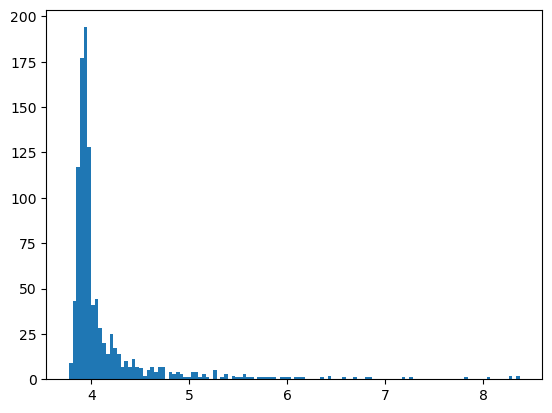

In [39]:
d = f['data'][:, 0, hit.frequency_index : hit.frequency_index+WINDOW_SIZE]
plt.hist(np.log10(d[8]), bins='auto');
# plt.axvline(1e4)
# plt.plot(d[8])

In [34]:
d[8]

array([ 7935.319,  8068.36 ,  8194.345, ..., 11127.072, 11925.986,
       10928.221], shape=(1024,), dtype=float32)

In [40]:
clipped, _, _ = scipy.stats.sigmaclip(d, low=3, high=3)

m = np.median(clipped)
std = np.std(clipped)

s = np.max(d)

print(f'{m=:.3g}\n{std=:.3g}\n{s=:.3g}\nSNR: {(s - m)/std:.3g}')

m=8.38e+03
std=1.14e+03
s=5.22e+08
SNR: 4.58e+05


In [15]:
hit.name

np.int64(1)

In [11]:
f['data'][8, 0, hit.frequency_index : hit.frequency_index+WINDOW_SIZE]

array([5534073. , 6725343. , 5269357.5, ..., 5234664. , 5585454. ,
       5854613.5], shape=(1024,), dtype=float32)

In [15]:
snrs = params_result[:, 2] * np.sqrt(np.pi / np.log(2)) / (2 * params_result[:, 3])

In [43]:
clipped_snrs, _, _ = scipy.stats.sigmaclip(snrs, 2, 2)

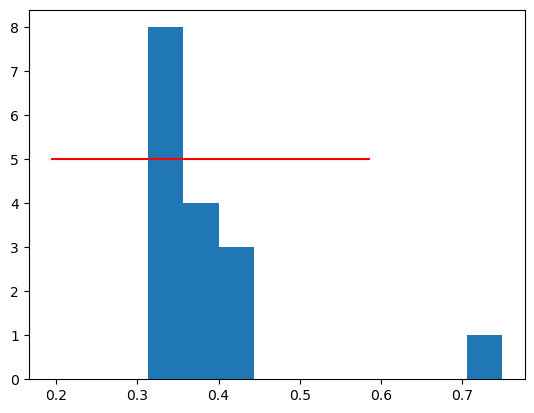

In [45]:
clipped_snrs.shape
plt.hist(snrs)
plt.hlines(5, np.mean(snrs) - 2*np.std(snrs), np.mean(snrs) + 2*np.std(snrs), color='red')

In [24]:
scipy.__version__

'1.15.2'

In [213]:
def save_hit_fig(hit, title=None, filename='image.png'):
    fig = make_figure(hit, title)
    fig.savefig(filename, transparent=False)

    plt.close(fig)

In [214]:
!rm scratch_images/*

In [215]:
df_normal = df[df['flags'].isna()]
if len(df_normal) > 25:
    df_normal = df_normal.sample(25) 
for i, (idx, normal_hit) in enumerate(df_normal.iterrows()):
    save_hit_fig(normal_hit, title=f'normal {idx}, freq={normal_hit['frequency']}, snr={normal_hit['snr']:.3g}', filename=f'scratch_images/normal_{i:>02}.png')

In [216]:
blip_df = df[df['flags'].str.contains('blip', na=False)]
if len(blip_df) > 25:
    blip_df = blip_df.sample(25)
for i, (idx, blip_hit) in enumerate(blip_df.iterrows()):
    save_hit_fig(blip_hit, title=f'blip {idx}, freq={normal_hit['frequency']}, snr={normal_hit['snr']:.3g},  {blip_hit['flags']}', filename=f'scratch_images/blip_{i:>03}.png')

In [217]:
bright_df = df[df['snr'] > 10]
if len(bright_df) >= 25:
    bright_df = bright_df.sample(25)
for i, (idx, bright_hit) in enumerate(bright_df.iterrows()):
    save_hit_fig(bright_hit, title=f'bright {idx}, freq={normal_hit['frequency']}, snr={bright_hit['snr']:.3g}, {bright_hit['flags']}', filename=f'scratch_images/bright_{i:>03}.png')

In [ ]:
normal_hit

frequency_index                                               610816
frequency                                               11249.756023
kurtosis                                                   61.765984
snr                                                        77.928703
width                                                       0.000048
flags                                                            NaN
source file        /datag/pipeline/AGBT20B_999_33/blc00_blp00/blc...
Name: 151, dtype: object